# How do Airbnb listing densities differ between New York City and Toronto?

Some EDA for RQ2: https://colab.research.google.com/drive/10XUYdl96FOKKCCgokTNbnTfy1edhv2Nv?usp=sharing

### Data Cleaning

In [ ]:

import pandas as pd

listings_nyc = pd.read_csv("/content/drive/MyDrive/Project/Data/listings_nyc.csv")


listings_toronto = pd.read_csv("/content/drive/MyDrive/Project/Data/listings_toronto.csv")


In [ ]:

num_columns_nyc = len(listings_nyc.columns)
num_columns_toronto = len(listings_toronto.columns)


column_names_nyc = set(listings_nyc.columns)
column_names_toronto = set(listings_toronto.columns)


print("Number of columns in NYC dataset:", num_columns_nyc)
print("Number of columns in Toronto dataset:", num_columns_toronto)
print("Column names in NYC dataset:", column_names_nyc)
print("Column names in Toronto dataset:", column_names_toronto)

# Check if the column names are identical
if column_names_nyc == column_names_toronto:
  print("Column names are identical in both datasets.")
else:
  print("Column names differ between the datasets.")


Number of columns in NYC dataset: 18
Number of columns in Toronto dataset: 18
Column names in NYC dataset: {'neighbourhood', 'host_id', 'last_review', 'number_of_reviews_ltm', 'neighbourhood_group', 'host_name', 'calculated_host_listings_count', 'minimum_nights', 'name', 'reviews_per_month', 'longitude', 'availability_365', 'latitude', 'license', 'id', 'number_of_reviews', 'room_type', 'price'}
Column names in Toronto dataset: {'neighbourhood', 'host_id', 'last_review', 'number_of_reviews_ltm', 'neighbourhood_group', 'host_name', 'calculated_host_listings_count', 'minimum_nights', 'name', 'reviews_per_month', 'longitude', 'availability_365', 'latitude', 'license', 'id', 'number_of_reviews', 'room_type', 'price'}
Column names are identical in both datasets.


Since the column names are identical, we don't have to do nearly as much cleaning

In [ ]:
# Drop unnecessary columns from both datasets
columns_to_drop = ['name', 'last_review', 'reviews_per_month', "host_name", "number_of_reviews",'number_of_reviews_ltm']


listings_toronto.drop(columns=columns_to_drop, inplace=True)
listings_nyc.drop(columns=columns_to_drop, inplace=True)

# Check for missing values in both datasets
missing_values_nyc = listings_nyc.isnull().sum()
missing_values_toronto = listings_toronto.isnull().sum()


In [ ]:
#grab without empty values
listings_nyc = listings_nyc[listings_nyc['price'].notna()]
listings_toronto = listings_toronto[listings_toronto['price'].notna()]


In [ ]:
listings_nyc.head()

,id,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,license
0,977395984065981849,95344065,Brooklyn,Sheepshead Bay,40.591790,-73.942850,Private room,30.0,31,7,339,NaN
1,729947657876634696,566660,Bronx,Longwood,40.827373,-73.903147,Private room,29.0,30,2,34,NaN
2,648033676238017128,421601513,Bronx,Kingsbridge,40.863940,-73.903120,Private room,30.0,30,3,359,NaN
3,623137142536549768,106442885,Brooklyn,East New York,40.660730,-73.890500,Entire home/apt,76.0,30,1,364,NaN
4,871990853610302281,484563208,Queens,Howard Beach,40.663586,-73.834532,Private room,85.0,30,2,89,NaN


## Create Heatmap

This will download HTML files that you can view.

In [ ]:
import folium
import folium.plugins as plugins
from IPython.display import IFrame



# Create a base map for New York City
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
# Create a heatmap layer for New York City listings
nyc_heatmap = plugins.HeatMap(listings_nyc[['latitude', 'longitude']].values.tolist(), radius=20)
# Add the heatmap layer to the map
nyc_map.add_child(nyc_heatmap)


toronto_map = folium.Map(location=[43.6532, -79.3832], zoom_start=12)

toronto_heatmap = plugins.HeatMap(listings_toronto[['latitude', 'longitude']].values.tolist(), radius=20)

toronto_map.add_child(toronto_heatmap)

# Save maps to HTML files
nyc_map.save('nyc_map.html')
toronto_map.save('toronto_map.html')




## Density Analysis



We break up the map into a grid where there are $1km^2$ cells. We then compare the how many AirBNB are in each of these grids.

In [ ]:
import pandas as pd
import numpy as np



def calculate_density(df):
    #bin sizes
    lat_bin_size = 0.01  # approximately 1 km at the equator
    lon_bin_size = 0.01

    # bin the latitude and longitude
    df['lat_bin'] = np.round(df['latitude'] / lat_bin_size) * lat_bin_size
    df['lon_bin'] = np.round(df['longitude'] / lon_bin_size) * lon_bin_size

    # group by binned latitude and longitude, and count listings
    grouped = df.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='counts')

    km_per_degree_latitude = 111  # rough estimate. can vary, but toronto is relatively flat
    area_per_bin_km2 = (lat_bin_size * km_per_degree_latitude) * (lon_bin_size * km_per_degree_latitude)  # Simplified

    # calculate density as listings per square kilometer
    grouped['density'] = grouped['counts'] / area_per_bin_km2

    return grouped

nyc_density = calculate_density(listings_nyc)
toronto_density = calculate_density(listings_toronto)


print("NYC Density Data:\n", nyc_density.head())
print("\nToronto Density Data:\n", toronto_density.head())




NYC Density Data:
    lat_bin  lon_bin  counts   density
0    40.50   -74.25       1  0.811622
1    40.50   -74.24       1  0.811622
2    40.51   -74.25       1  0.811622
3    40.51   -74.24       2  1.623245
4    40.52   -74.22       2  1.623245

Toronto Density Data:
    lat_bin  lon_bin  counts    density
0    43.59   -79.55       2   1.623245
1    43.59   -79.54      36  29.218408
2    43.59   -79.53      13  10.551092
3    43.59   -79.52       1   0.811622
4    43.59   -79.51       3   2.434867


Average density in NYC: 28.461909808574386
Average density in Toronto: 20.59460899034417
Median density in NYC: 8.927846765684603
Median density in Toronto: 8.116224332440547
Maximum count in NYC: 766
Maximum count in Toronto: 873


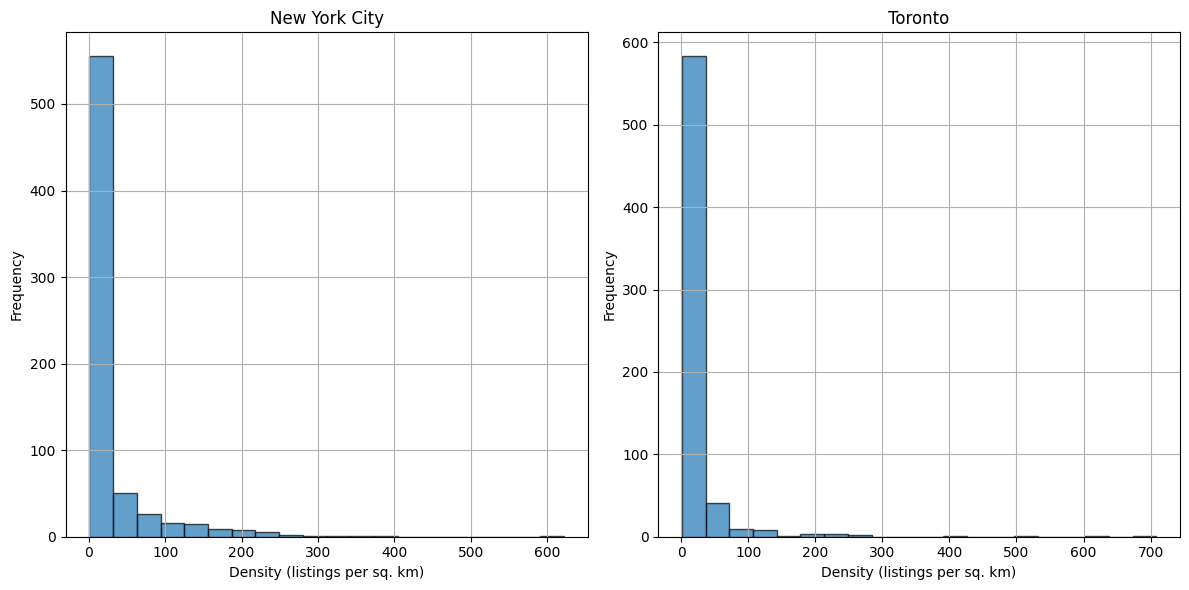

In [ ]:

print("Average density in NYC:", nyc_density['density'].mean())
print("Average density in Toronto:", toronto_density['density'].mean())

print("Median density in NYC:", nyc_density['density'].median())
print("Median density in Toronto:", toronto_density['density'].median())


print("Maximum count in NYC:", nyc_density['counts'].max())
print("Maximum count in Toronto:", toronto_density['counts'].max())


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nyc_density['density'].hist(bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Density (listings per sq. km)')
plt.ylabel('Frequency')
plt.title('New York City')

plt.subplot(1, 2, 2)
toronto_density['density'].hist(bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Density (listings per sq. km)')
plt.ylabel('Frequency')
plt.title('Toronto')

plt.tight_layout()
plt.show()




From this chart, it's evident that most AirBnbs are mostly only in a few areas.

### Creating Densities of Neighbourhoods with GEOJSON

Note after I wrote this notebook:

It's really odd, but when I first was examining the CSV, I was getting the result that the neighbourhood column was empty on both datasets, but it ended up being an error because the "neighbourhood" column on both datasets is completely full. I could have used just a much easier method since I already had access to the neighbourhood for each listing.


It's still good that I used this method, since now I can have the GEOJSON files for future graphing. This is more of a proof of concept now, I suppose.

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# NYC GEOJSON source: https://github.com/veltman/snd3/blob/master/data/nyc-neighborhoods.geo.json
# Toronto GEOJSON source: https://github.com/jasonicarter/toronto-geojson/blob/master/toronto_crs84.geojson

toronto_neighbourhoods = gpd.read_file("/content/drive/MyDrive/Project/Data/toronto_neighbourhoods.geojson")
nyc_neighbourhoods = gpd.read_file("/content/drive/MyDrive/Project/Data/nyc_subneighbourhoods.geojson")

# convert DataFrame to GeoDataFrame
nyc_density['geometry'] = nyc_density.apply(lambda row: Point(row['lon_bin'], row['lat_bin']), axis=1)
nyc_density_gdf = gpd.GeoDataFrame(nyc_density, geometry='geometry')

# this is the google maps standard
nyc_density_gdf.crs = "EPSG:3785"

# spatial join with NYC neighborhoods
nyc_density_with_neighbourhoods = gpd.sjoin(nyc_density_gdf, nyc_neighbourhoods, how="left", op="within")

# convert again for toronto
toronto_density['geometry'] = toronto_density.apply(lambda row: Point(row['lon_bin'], row['lat_bin']), axis=1)
toronto_density_gdf = gpd.GeoDataFrame(toronto_density, geometry='geometry')

toronto_density_gdf.crs = "EPSG:3785"

# spatial join with Toronto neighborhoods
toronto_density_with_neighbourhoods = gpd.sjoin(toronto_density_gdf, toronto_neighbourhoods, how="left", op="within")

# nyc_density_with_neighbourhoods and toronto_density_with_neighbourhoods contain the original density data plus
# the corresponding neighborhood information for each point.


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-9-ad748dc923a4>:19: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3785
Right CRS: EPSG:4326

  nyc_density_with_neighbourhoods = gpd.sjoin(nyc_density_gdf, nyc_neighbourhoods, how="left", op="within")
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-9-ad748dc923a4>:28: UserWarning: CRS mismatch between the CRS of left geometries

In [ ]:
nyc_sorted_by_density = nyc_density_with_neighbourhoods.sort_values(by='density', ascending=False)
print("NYC neighborhoods by highest density:\n")
print(nyc_sorted_by_density[['neighborhood', 'density']].head())


toronto_sorted_by_density = toronto_density_with_neighbourhoods.sort_values(by='density', ascending=False)
print("\nToronto neighborhoods by highest density:\n")
print(toronto_sorted_by_density[['AREA_NAME', 'density']].head())

NYC neighborhoods by highest density:

        neighborhood     density
490   Hell's Kitchen  621.702784
464          Chelsea  404.187972
465      Murray Hill  344.127912
389  Lower East Side  341.693044
491          Midtown  296.242188

Toronto neighborhoods by highest density:

                                  AREA_NAME     density
63   Waterfront Communities-The Island (77)  708.546384
65   Waterfront Communities-The Island (77)  609.528447
88   Waterfront Communities-The Island (77)  501.582664
64   Waterfront Communities-The Island (77)  404.999594
142                              Annex (95)  262.154046


In [ ]:
!pip install mapclassify

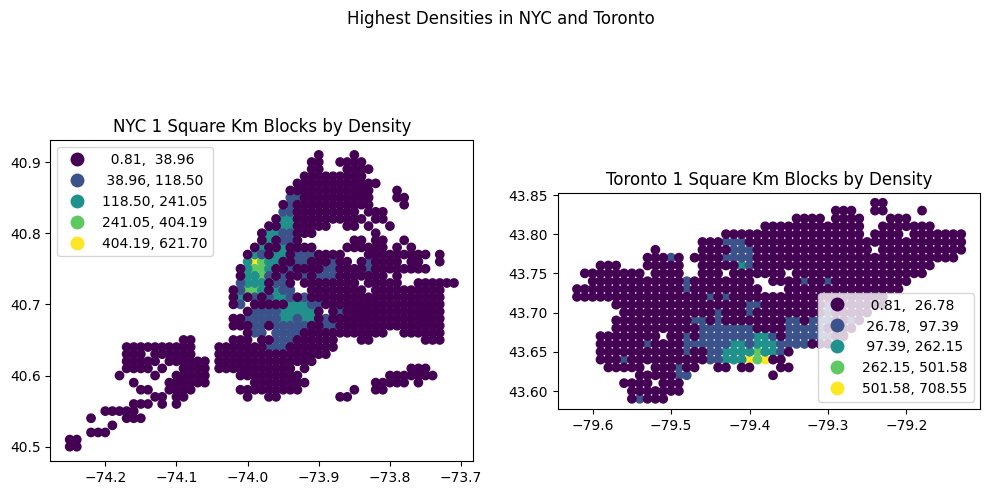

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


nyc_sorted_by_density.plot(ax=ax1, column='density', legend=True, scheme='NaturalBreaks')
ax1.set_title('NYC 1 Square Km Blocks by Density')

toronto_sorted_by_density.plot(ax=ax2, column='density', legend=True, scheme='NaturalBreaks')
ax2.set_title('Toronto 1 Square Km Blocks by Density')


plt.suptitle('Highest Densities in NYC and Toronto')
plt.show()


In [ ]:

nyc_average_density_by_neighbourhood = nyc_density_with_neighbourhoods.groupby('neighborhood')['density'].mean().sort_values(ascending=False)


print("Top 5 Densest Neighbourhoods in NYC:")
print(nyc_average_density_by_neighbourhood.head(5))


toronto_average_density_by_neighbourhood = toronto_density_with_neighbourhoods.groupby('AREA_NAME')['density'].mean().sort_values(ascending=False)


print("\nTop 5 Densest Neighbourhoods in Toronto:")
print(toronto_average_density_by_neighbourhood.head(5))


Top 5 Densest Neighbourhoods in NYC:
neighborhood
Murray Hill       344.127912
Hell's Kitchen    310.580851
Kips Bay          279.198117
SoHo              270.270270
Chelsea           259.178097
Name: density, dtype: float64

Top 5 Densest Neighbourhoods in Toronto:
AREA_NAME
Kensington-Chinatown (78)                 256.472689
Church-Yonge Corridor (75)                204.934664
Waterfront Communities-The Island (77)    192.760328
Trinity-Bellwoods (81)                    184.644104
Moss Park (73)                            167.194221
Name: density, dtype: float64


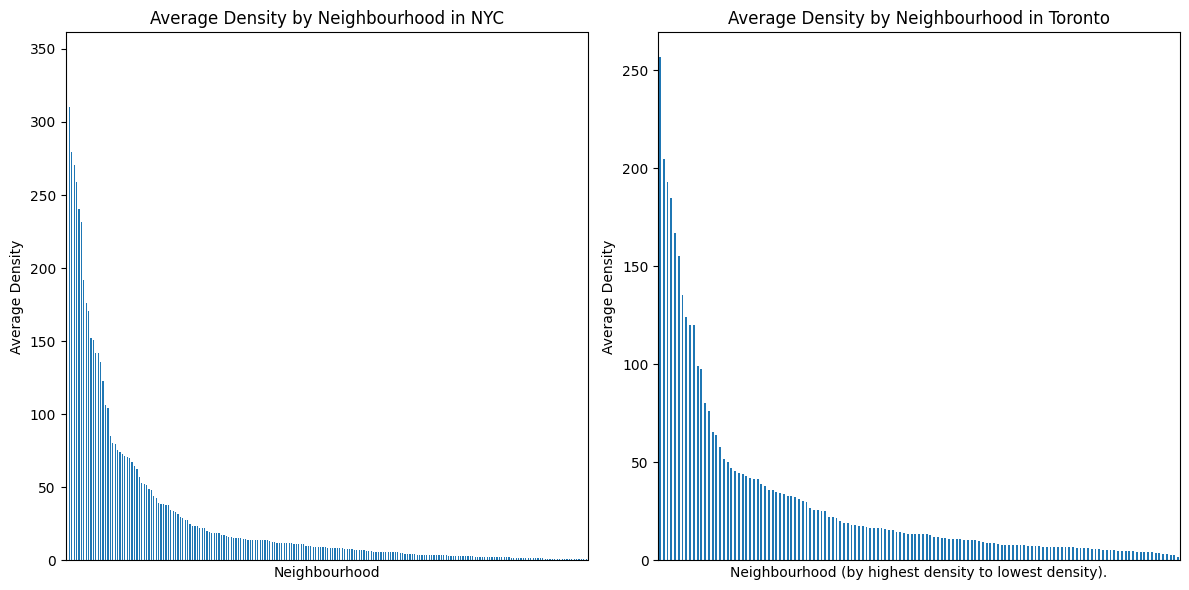

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nyc_average_density_by_neighbourhood.plot(kind='bar')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Density')
plt.title('Average Density by Neighbourhood in NYC')
plt.tick_params(axis='x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=False)




plt.subplot(1, 2, 2)
toronto_average_density_by_neighbourhood.plot(kind='bar')
plt.xlabel('Neighbourhood (by highest density to lowest density).')
plt.ylabel('Average Density')
plt.title('Average Density by Neighbourhood in Toronto')
plt.tick_params(axis='x',
                which='both',
                bottom=False,
                top=False,
                labelbottom=False)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Top 5 and Bottom 5 Average Density by Neighbourhood in Toronto')

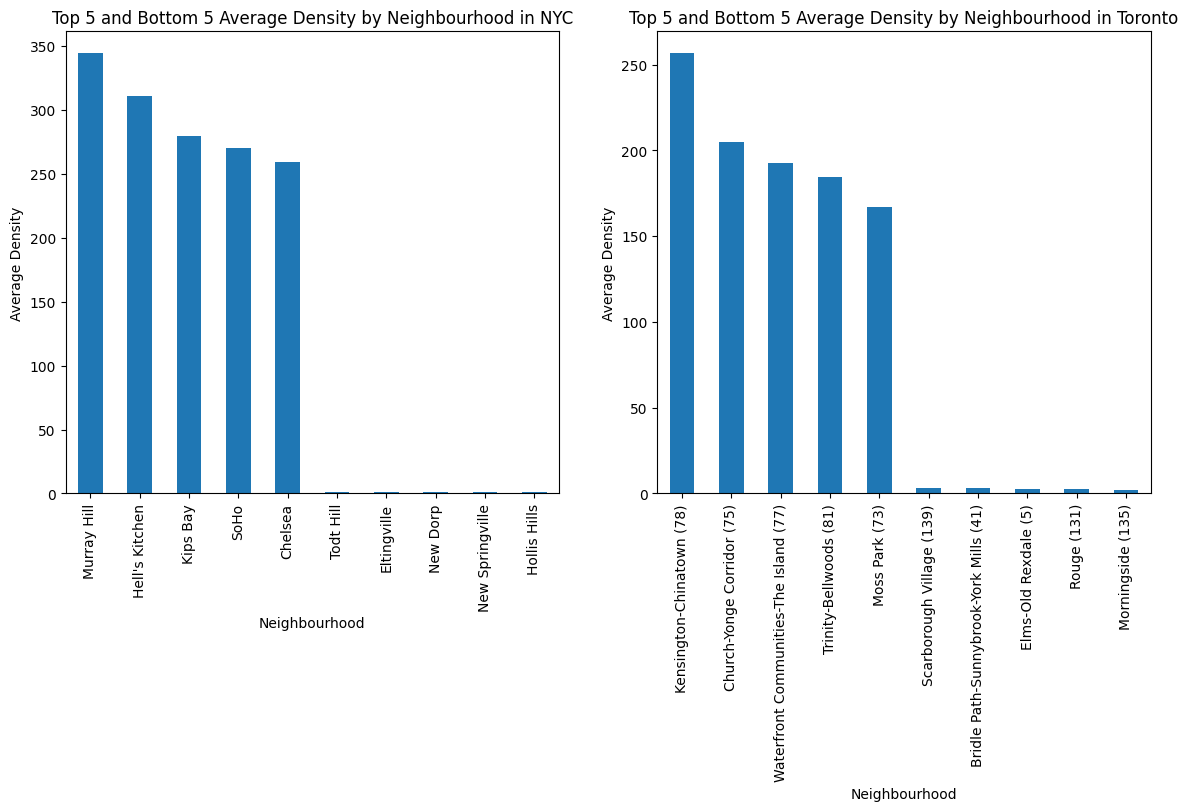

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

n = 5

# Select top N and bottom N neighbourhoods for NYC
nyc_top_n = nyc_average_density_by_neighbourhood.head(n)
nyc_bottom_n = nyc_average_density_by_neighbourhood.tail(n)
nyc_combined = pd.concat([nyc_top_n, nyc_bottom_n])

# Select top N and bottom N neighbourhoods for Toronto
toronto_top_n = toronto_average_density_by_neighbourhood.head(n)
toronto_bottom_n = toronto_average_density_by_neighbourhood.tail(n)
toronto_combined = pd.concat([toronto_top_n, toronto_bottom_n])

plt.figure(figsize=(14, 6))

# NYC
plt.subplot(1, 2, 1)
nyc_combined.plot(kind='bar')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Density')
plt.title('Top 5 and Bottom 5 Average Density by Neighbourhood in NYC')


# Toronto
plt.subplot(1, 2, 2)
toronto_combined.plot(kind='bar')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Density')
plt.title('Top 5 and Bottom 5 Average Density by Neighbourhood in Toronto')



